In [5]:
! kaggle datasets download -d nikdavis/steam-store-games --force --unzip


  0%|          | 0.00/35.2M [00:00<?, ?B/s]
  3%|2         | 1.00M/35.2M [00:00<00:04, 7.60MB/s]
 28%|##8       | 10.0M/35.2M [00:00<00:00, 49.5MB/s]
 45%|####5     | 16.0M/35.2M [00:00<00:00, 50.9MB/s]
 65%|######5   | 23.0M/35.2M [00:00<00:00, 58.0MB/s]
 82%|########2 | 29.0M/35.2M [00:00<00:00, 58.0MB/s]
 99%|#########9| 35.0M/35.2M [00:00<00:00, 58.5MB/s]
100%|##########| 35.2M/35.2M [00:00<00:00, 53.9MB/s]


In [34]:
! pip install xgboost

     --------------------------------------- 70.9/70.9 MB 13.1 MB/s eta 0:00:00


In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [92]:
data = pd.read_csv('steam.csv')
data = data.drop('appid', axis=1)
data = data.drop('positive_ratings', axis=1)
data = data.drop('negative_ratings', axis=1)
data = data.drop('average_playtime', axis=1)
data = data.drop('median_playtime', axis=1)

In [93]:
data['required_age'].fillna(0, inplace=True)
data['price'].fillna(data['price'].mean(), inplace=True)


In [94]:
data['owners_mid'] = data['owners'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) / 2)


In [95]:
from sklearn.preprocessing import MultiLabelBinarizer

# Select columns to encode
cat_columns = ['developer', 'publisher', 'platforms', 'categories', 'genres', 'steamspy_tags']

# MultiLabelBinarizer for multiple value columns
multi_label_binarizer = MultiLabelBinarizer()
multi_val_columns = ['platforms', 'categories', 'genres', 'steamspy_tags']

for col in multi_val_columns:
    data[col] = data[col].apply(lambda x: x.split(';'))
    one_hot_encoded = multi_label_binarizer.fit_transform(data[col])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=[f"{col}_{category}" for category in multi_label_binarizer.classes_])
    data = pd.concat([data, one_hot_encoded_df], axis=1)

# LabelEncoder for single value columns
label_encoder = LabelEncoder()
single_val_columns = ['developer', 'publisher']

for col in single_val_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Drop original columns after encoding
data.drop(cat_columns, axis=1, inplace=True)


In [96]:
# num_columns = ['required_age', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price']
num_columns = ['required_age', 'achievements', 'price']

scaler = MinMaxScaler()
data[num_columns] = scaler.fit_transform(data[num_columns])


In [97]:
X = data.drop(['name', 'release_date', 'owners', 'owners_mid'], axis=1)

# data['owners_log'] = np.log1p(data['owners_mid'])
# y = data['owners_log']
y = data['owners_mid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [98]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)


LinearRegression()

In [99]:
y_pred = linear_regression.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 6.7049355640226415e+31


In [100]:
X_train

,english,required_age,achievements,price,platforms_linux,platforms_mac,platforms_windows,categories_Captions available,categories_Co-op,categories_Commentary available,...,steamspy_tags_Warhammer 40K,steamspy_tags_Web Publishing,steamspy_tags_Werewolves,steamspy_tags_Western,steamspy_tags_Word Game,steamspy_tags_World War I,steamspy_tags_World War II,steamspy_tags_Wrestling,steamspy_tags_Zombies,steamspy_tags_e-sports
1807,1,0.0,0.005091,0.040262,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25093,1,0.0,0.000000,0.042631,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8355,1,0.0,0.001935,0.016564,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6151,1,0.0,0.003666,0.026043,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21814,1,0.0,0.000509,0.023674,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,1,0.0,0.000916,0.001872,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,1,0.0,0.011302,0.000000,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,1,0.0,0.000000,0.009455,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
15795,1,0.0,0.003666,0.009455,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_regressor.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [102]:
y_pred = xgb_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 1442896477706.6008


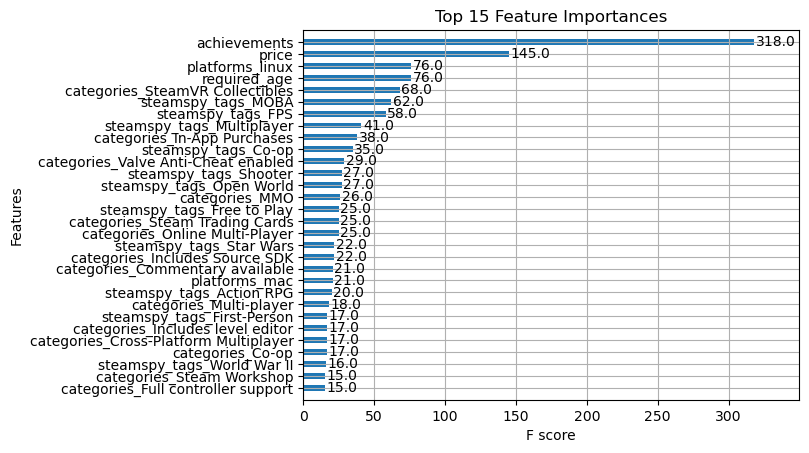

In [103]:
# ! pip install xgboost matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot the top 15 feature importances
xgb.plot_importance(xgb_regressor, max_num_features=30, height=0.5)
plt.title("Top 15 Feature Importances")
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'head'